# Simple: get IBOV tickers and print a few

Run the code cell below. It imports `obter_tickers_yfinance` from `data/data.py`, tries to scrape, and falls back to two example tickers if scraping fails.

In [58]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [59]:
# Ensure repository root is on sys.path if notebook is inside 'notebooks/'
repo_root = Path.cwd()
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from data.data import obter_tickers_yfinance

# Use the function
tickers = obter_tickers_yfinance()


In [60]:
dados = yf.download(tickers, period="10y")
df = dados.stack(level=1)
df = df.reset_index().rename(columns={'level_1': 'Ticker'}) 
df = df.fillna(method='ffill').fillna(method='bfill')


/tmp/ipykernel_4680/1282441585.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers, period="10y")
[*********************100%***********************]  82 of 82 completed
/tmp/ipykernel_4680/1282441585.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = dados.stack(level=1)
/tmp/ipykernel_4680/1282441585.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [61]:
# df = df[df['Ticker'] == 'ABEV3.SA'].reset_index(drop=True)

df = df[['Date', 'Close','Ticker']]

df

Price,Date,Close,Ticker
0,2015-12-16,12.231484,ABEV3.SA
1,2015-12-16,4.294980,AXIA3.SA
2,2015-12-16,6.539781,AXIA6.SA
3,2015-12-16,17.337248,AZZA3.SA
4,2015-12-16,2.803693,B3SA3.SA
...,...,...,...
177476,2025-12-16,25.160000,VBBR3.SA
177477,2025-12-16,34.889999,VIVA3.SA
177478,2025-12-16,33.049999,VIVT3.SA
177479,2025-12-16,49.630001,WEGE3.SA


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

In [64]:
def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 50
x, y = create_sequences(scaled_data, seq_length)
x.shape, y.shape

((177431, 50, 1), (177431, 1))

In [65]:
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [66]:

X_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_train.size(), x_train.size()

/tmp/ipykernel_4680/1350729056.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_4680/1350729056.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_4680/1350729056.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(x_test, dtype=torch.float32)
/tmp/ipykernel_4680/1350729056.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() 

(torch.Size([141944, 1]), torch.Size([141944, 50, 1]))

In [67]:
input_size = 1
hidden_size = 64
num_layers = 2 
output_size = 1
dropout = 0.2   

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out
    
model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers,dropout=dropout).to(device)

# Loss for training/backprop
loss_mse = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# --- Regression metrics (torch tensors) ---
def rmse(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

loss_rmse = rmse

def mae(preds, targets):
    return torch.mean(torch.abs(preds - targets))

loss_mae = mae



print(model)
print(len(list(model.parameters())))


LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
10


In [69]:
# Train model
#####################
epochs = 100
batch_size = 256

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

hist_mse = np.zeros(epochs)
hist_rmse = np.zeros(epochs)
hist_mae = np.zeros(epochs)

model.train()

for  epoch in range(epochs):
    mse_sum = rmse_sum = mae_sum  = 0.0

    for x_batch, y_batch in train_loader:
        optimiser.zero_grad()

        y_pred = model(x_batch)
        mse_val = loss_mse(y_pred, y_batch)
        rmse_val = loss_rmse(y_pred, y_batch)
        mae_val = loss_mae(y_pred, y_batch)

        mse_val.backward()
        optimiser.step()

        mse_sum += mse_val.item()
        rmse_sum += rmse_val.item()
        mae_sum += mae_val.item()

    hist_mse[epoch] = mse_sum / len(train_loader)
    hist_rmse[epoch] = rmse_sum / len(train_loader)
    hist_mae[epoch] = mae_sum / len(train_loader)

    if epoch % 10 == 0 and epoch != 0:
        print(f"Epoch {epoch} - MSE: {hist_mse[epoch]:.6f}, RMSE: {hist_rmse[epoch]:.6f}, MAE: {hist_mae[epoch]:.6f}")

# Predição do conjunto de treino para uso posterior
model.eval()
with torch.no_grad():
    y_train_pred = model(x_train)

Epoch 10 - MSE: 0.001863, RMSE: 0.039231, MAE: 0.014962
Epoch 20 - MSE: 0.001859, RMSE: 0.039100, MAE: 0.014857
Epoch 30 - MSE: 0.001866, RMSE: 0.039192, MAE: 0.014880
Epoch 40 - MSE: 0.001858, RMSE: 0.039081, MAE: 0.014819
Epoch 50 - MSE: 0.001862, RMSE: 0.039281, MAE: 0.014875
Epoch 60 - MSE: 0.001859, RMSE: 0.039089, MAE: 0.014824
Epoch 70 - MSE: 0.001861, RMSE: 0.039079, MAE: 0.014866
Epoch 80 - MSE: 0.001864, RMSE: 0.039043, MAE: 0.014928
Epoch 90 - MSE: 0.001859, RMSE: 0.039159, MAE: 0.014865


RuntimeError: [enforce fail at alloc_cpu.cpp:124] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 15779638280 bytes. Error code 12 (Cannot allocate memory)

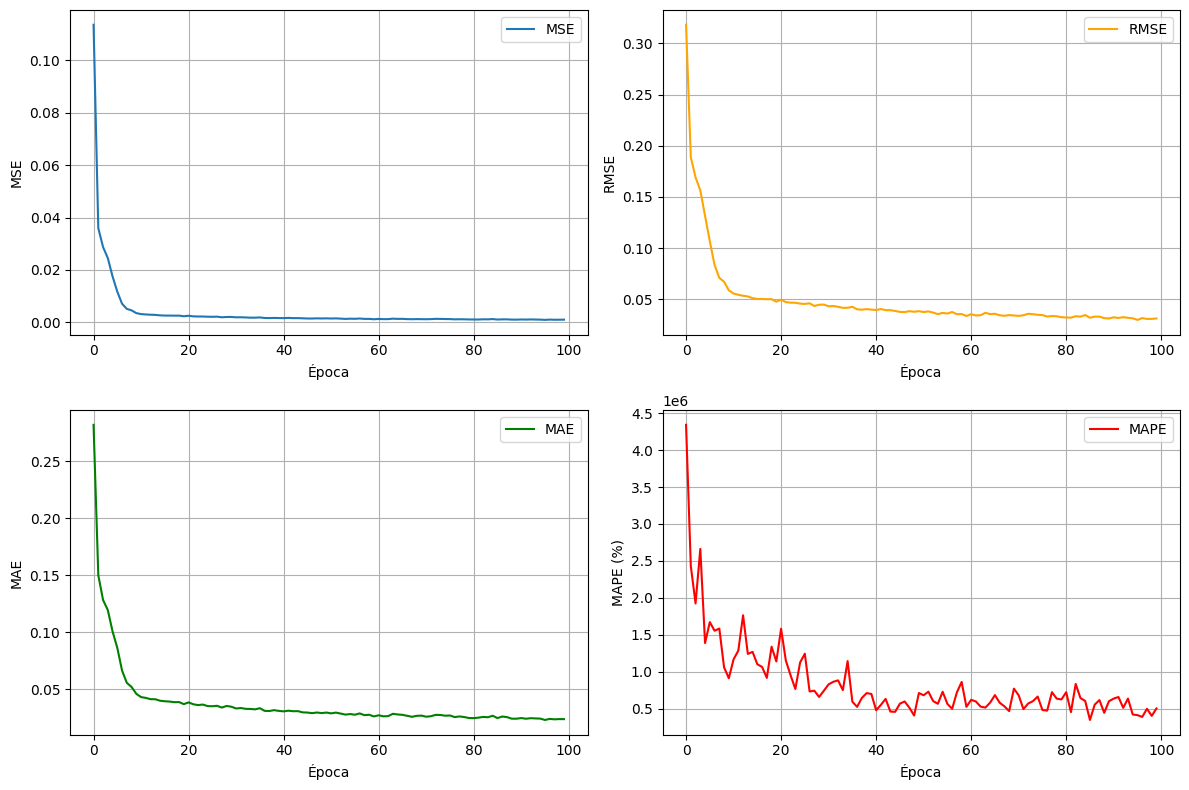

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(hist_mse, label="MSE")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(hist_rmse, label="RMSE", color='orange')
plt.xlabel("Época")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(hist_mae, label="MAE", color='green')
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [70]:
import os, joblib
os.makedirs("artifacts", exist_ok=True)

# Save PyTorch weights (state_dict)
torch.save(model.state_dict(), "artifacts/stock_lstm.pt")

# Save the fitted MinMaxScaler
joblib.dump(scaler, "artifacts/scaler.joblib")

print("Saved artifacts:", "artifacts/stock_lstm.pt", "artifacts/scaler.joblib")

Saved artifacts: artifacts/stock_lstm.pt artifacts/scaler.joblib


In [ ]:
# Inference on ABEV3.SA using 2025 data
from src.model_utils import load_artifacts, predict_next
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# 1) Download 2025 daily closes
ticker = "ABEV3.SA"
start = "2025-01-01"
df_2025 = yf.download(ticker, start=start)
closes = df_2025["Close"].dropna().astype(np.float32)
print(f"Fetched {len(closes)} daily closes for {ticker} since {start}")

# 2) Load saved artifacts and predict next close
model, scaler = load_artifacts()  # expects artifacts/stock_lstm.pt and artifacts/scaler.joblib
window = 50
arr = closes.values.reshape(-1, 1)
scaled = scaler.transform(arr)

if len(scaled) < window:
    raise ValueError(f"Need at least {window} points, got {len(scaled)}")

seq = scaled[-window:]
predicted = predict_next(model, scaler, seq)
print(f"Predicted next close for {ticker}: {predicted:.4f}")

# 3) Optional: visualize recent window vs predicted next
plt.figure(figsize=(10, 4))
plt.plot(closes.index[-window:], closes.values[-window:], label="Recent Close")
plt.axhline(predicted, color="orange", linestyle="--", label="Predicted next")
plt.title(f"{ticker} 2025 recent closes + next prediction")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()